# Detection Model Training and Testing Notebook

This notebook demonstrates how to train a simple detection model using PyTorch and then test it on new data. The notebook is divided into several sections: 

1. **Imports and Data Preparation**: Loading the dataset and creating feature representations for each image.
2. **Dataset and Dataloader**: Creating a custom dataset class to handle our data.
3. **Model Definition and Training**: Defining the neural network model, training it, and printing the loss per epoch.
4. **Testing the Model**: Loading new data, running the model in evaluation mode, and printing out predictions or test loss.


In [28]:
import numpy as np
from functools import reduce
from io import BytesIO

# Data handling
import pandas as pd
import polars as pl

# Scikit-learn
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score,auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# XGBoost
from xgboost import XGBRegressor, XGBClassifier


# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import Image
from tqdm import tqdm
%matplotlib inline

In [17]:
df = pl.read_csv(
    "labeled_data.txt",
    separator=" ",
    has_header=False,
)

df.columns = ["image_file", "class_id", "x1", "y1", "x2", "y2"]

df = df.drop("image_file")
X = df.drop("class_id")
y = df["class_id"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_rf = RandomForestClassifier(n_estimators=30, # Number of trees to train
                       criterion='entropy', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.01, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='sqrt', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=20190305, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced', # Balance classes.
                                    )

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Overall ROC AUC (OVR): 1.00


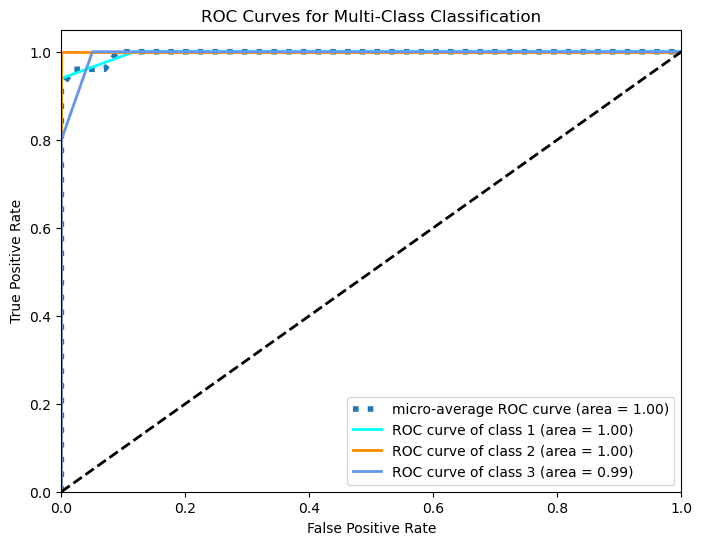

In [ ]:


# Assume y_test contains the true labels and model_rf is your trained model.
# Compute the predicted probabilities
y_score = model_rf.predict_proba(X_test)

# Binarize the output labels for multi-class ROC computation.
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area.
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Optionally, compute the overall ROC AUC score using OVR approach (as in your provided code).
overall_roc_auc = roc_auc_score(y_test, y_score, multi_class='ovr')
print("Overall ROC AUC (OVR): {:.2f}".format(overall_roc_auc))

# Plotting the ROC curves.
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve.
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         linestyle=':', linewidth=4)

# Define colors for each class (adjust as needed).
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

In [25]:
y_pred = model_rf.predict(X_test)
roc = roc_auc_score(y_test, model_rf.predict_proba(X_test), multi_class='ovr')
print(f"ROC AUC: {roc}")


ROC AUC: 0.9971449792038026


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
